In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from icecream import ic
from import_casa import casa

In [9]:
data_dir = casa.get_data_path() / "eda\context"
with open(data_dir / "ctx_logits.pkl", "rb") as fin:
    logits = pickle.load(fin)
with open(data_dir / "ctx_predictions.pkl", "rb") as fin:
    preds = pickle.load(fin)

In [8]:
logits.shape

(436, 512, 5)

In [ ]:
label_list = ['B-VN', 'B-VP', 'I-VN', 'I-VP', 'O']

In [183]:
context_v = pd.read_excel(data_dir / "context_v.xlsx", sheet_name=0, index_col=False)
last_col_idx = np.where(context_v.columns.values == "cues")[0][0]
context_v = context_v.iloc[:, 1:last_col_idx]
info = context_v.iloc[:,5]

In [199]:
texts = context_v.context.str.replace(' ', '').tolist()
rating = context_v.rating

In [107]:
logits_pn = np.zeros((logits.shape[0], logits.shape[1]-1, 2), dtype=np.float32)
logits_pn[:, :, 1] = logits[:, 1:, [0, 2]].sum(axis=-1)
logits_pn[:, :, 0] = logits[:, 1:, [1, 3]].sum(axis=-1)

In [108]:
for text_i, text_x in enumerate(texts):
    if len(text_x) >= 512:
        continue
    logits_pn[text_i, len(text_x):, :] = np.nan

In [109]:
from matplotlib import pyplot as plt

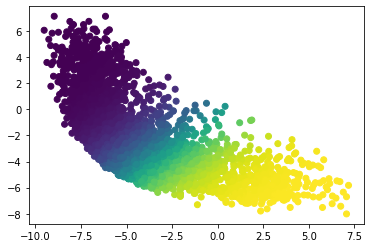

In [119]:
logits_p = logits_pn[:, :, 0].flatten()
logits_n = logits_pn[:, :, 1].flatten()
T = 2
prob_pn = np.exp(logits_p/T) / (np.exp(logits_p/T)+np.exp(logits_n/T))
plt.scatter(logits_p, logits_n, c=prob_pn)

In [139]:
data = []
for text_i, text_x in enumerate(texts):
    if len(text_x) >= 512:
        continue
    seq = []
    T = 4
    logits_p = logits_pn[text_i, :, 0].flatten()
    logits_n = logits_pn[text_i, :, 1].flatten()
    norm = np.log(np.linalg.norm(np.vstack(np.exp([logits_p, logits_n])), axis=0))
    prob_pn = np.exp(logits_p/T) / (np.exp(logits_p/T)+np.exp(logits_n/T))
    for ch_i, ch in enumerate(text_x):
        seq.append((ch, prob_pn[ch_i], norm[ch_i]))
    data.append(seq)

In [166]:
np.quantile([tok[2] for seq in data for tok in seq], [.9,.95])

array([0.27912365, 2.41804069])

(array([3482., 3178., 1155.,  518.,  307.,  260.,  241.,  153.,   61.,
          27.]),
 array([-4.865668  , -3.6617453 , -2.457823  , -1.2539005 , -0.04997816,
         1.1539443 ,  2.3578668 ,  3.561789  ,  4.7657113 ,  5.969634  ,
         7.1735563 ], dtype=float32),
 <a list of 10 Patch objects>)

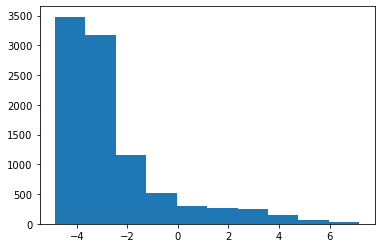

In [146]:
plt.hist([tok[2] for seq in data for tok in seq])

In [162]:
hot_cm(0.5)

(1.0, 0.359314099938117, 0.0, 1.0)

In [201]:
from io import StringIO

thres = np.quantile([tok[2] for seq in data for tok in seq], [.25])[0]
hot_cm = plt.get_cmap("coolwarm")
def rgb2css(rgba, a=None):
    r, g, b, aval = rgba
    if not a:
        a = 0.5
    return f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})"

sio = StringIO()
sio.write("<!DOCTYPE HTML>\n")
sio.write("<html>\n")
sio.write("<head>\n")
sio.write("<title>context token classification visualization</title>\n")
sio.write(f"""<style>
.seq-wrap {{
    margin: 1% 1%; padding: 1% 1%;
    display:flex;
    border-left: 10px solid black;
}}
.text{{max-width: 60%; font-size: 16pt; }}
.supp{{margin-left: 1%; font-size: 12pt; align-self: flex-end}}
.pos {{border-color: {rgb2css(hot_cm(0.8), 1)}}}
.neg {{border-color: {rgb2css(hot_cm(0.2), 1)}}}
.unk {{border-color: {rgb2css(hot_cm(0.5), 1)}}}
</style>\n""")
sio.write("</head>\n")
sio.write("<body>\n")
sio.write("<div style='width: 90%; margin:auto'>")
for seq, score, supp in zip(data, rating, info):
    if score >= 3.0:
        sio.write("<div class='seq-wrap pos'>\n")
    elif 0 <= score < 3.0:
        sio.write("<div class='seq-wrap neg'>\n")
    else:
        sio.write("<div class='seq-wrap unk'>\n")
    
    sio.write("<div class='text'>")
    for tok in seq:
        if tok[2] > thres:            
            sio.write(f"<span style='background-color:")
            sio.write(f"{rgb2css(hot_cm(tok[1]))}'>")
        else:
            hval = 0
            sio.write(f"<span style=''>")
        sio.write(f"{tok[0]}</span>")
    sio.write("</div>")
    sio.write(f"<div class='supp'>{supp}</div>")
    sio.write("</div>\n")
sio.write("<div> <!-- div.wrapper -->")
sio.write("</body>\n</html>\n")
with open("h:/context_vis_token.html", "w", encoding="utf-8") as fout:
    fout.write(sio.getvalue())

In [202]:
tok_preds = []
thres = np.quantile([tok[2] for seq in data for tok in seq], [.25])[0]
for seq in data:
    pos_tok = [x[1] > 0.5 for x in seq if x[2] > thres]
    neg_tok = [x[1] < 0.5 for x in seq if x[2] > thres]
    tok_preds.append(1 if pos_tok > neg_tok else 0)

In [209]:
from sklearn.metrics import classification_report, accuracy_score

In [212]:
pn_map = ["Negative", "Positive"]
preds = [x for x, r in zip(tok_preds, rating) if r >= 0]
labels = [x>=3 for x in rating if x >= 0]
preds = [pn_map[int(x)] for x in preds]
labels = [pn_map[int(x)] for x in labels]

In [213]:
accuracy_score(labels, preds)

0.7128953771289538

In [214]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

    Negative       0.71      0.86      0.78       239
    Positive       0.72      0.51      0.60       172

    accuracy                           0.71       411
   macro avg       0.72      0.68      0.69       411
weighted avg       0.72      0.71      0.70       411

